## Objetivos

Aplicar al conjunto de datos proporcionado los métodos o algoritmos Árboles y Random Forest para predecir (regresión) el número de ventas de bicicletas por hora.

## Descripción de la Actividad

- Análisis descriptivo de los datos.
- Determinar el conjunto de modelización y el de validación.
- Tratamiento de missing (si los hay).
- Tratamiento de variables categóricas.
- Calcular las métricas de evaluación de ajuste adecuadas.
- Comparar mediante las medidas que parezcan adecuadas la capacidad predictiva de ambos métodos.
- Comentar los resultados obtenidos.
- Otros comentarios que parezcan adecuados.
- Repite el ejercicio haciendo el siguiente grupo y desarrollando un algoritmo de clasificación: grupo 1 si cnt<=20, grupo 2 en otro caso.

## Desarrollo

In [82]:
# importar librerias necesarias
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline

In [83]:
# importar datos desde el archivo hour.csv, este archivo está dentro de la carpeta "dataset"
df = pd.read_csv('hour2.csv')

In [84]:
# mostrar las 5 primeras filas del dataframe
df.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01/01/2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16.01
1,2,01/01/2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40.00
2,3,01/01/2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32.00
3,4,01/01/2011,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13.00
4,5,01/01/2011,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1.00


### Tratamiento de datos

Se eliminan las columnas instant, dteday, casual y registered. No son necesarias para entrenar el modelo. 
* **instant** se elimina ya que solamente corresponde a un identificador secuencial
* **dteday** se elimina ya que es una fecha que no aporta a la predicción
* **casual** y **registered** corresponden a la suma del valor de cnt, por lo que si estan presentes no justificaría una predicción.

In [85]:
# se eliminan las columnas instant, dteday, yr, casual, registered
#df = df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)
df = df.drop(['instant', 'dteday'], axis=1)

# variables categóricas
cat_attr_list = ['season','yr', 'mnth','hr', 'holiday','weekday','workingday','weathersit']

for col in cat_attr_list:
    df[col] = df[col].astype('category')

# se muestra las 5 primeras filas del dataframe
df.head(5)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16.01
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40.00
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32.00
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13.00
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1.00


In [86]:
# Obtener la dimensión del dataframe
df.shape

(17379, 15)

In [87]:
# Verificar si existen datos missing en nuestro dataset
df.isnull().values.any()

False

Se revisa que las variables se encuentren adecuadamente clasificadas, en categóricas y numéricas.
La variable a predecir "cnt" es numérica ya que se trata de un algoritmo de regresión.

In [88]:
# Obtener la información de los datos del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      17379 non-null  category
 1   yr          17379 non-null  category
 2   mnth        17379 non-null  category
 3   hr          17379 non-null  category
 4   holiday     17379 non-null  category
 5   weekday     17379 non-null  category
 6   workingday  17379 non-null  category
 7   weathersit  17379 non-null  category
 8   temp        17379 non-null  float64 
 9   atemp       17379 non-null  float64 
 10  hum         17379 non-null  float64 
 11  windspeed   17379 non-null  float64 
 12  casual      17379 non-null  int64   
 13  registered  17379 non-null  int64   
 14  cnt         17379 non-null  float64 
dtypes: category(8), float64(5), int64(2)
memory usage: 1.1 MB


Generar estadísticas descriptivas que resuman la tendencia central, la dispersión y la forma de la distribución del conjunto de datos. Esta información solamente se presenta de las columnas que son de tipo numérico, pues de las demás no se calculan.

In [89]:
df.describe()

,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


#### Distribución de datos en variables categóricas

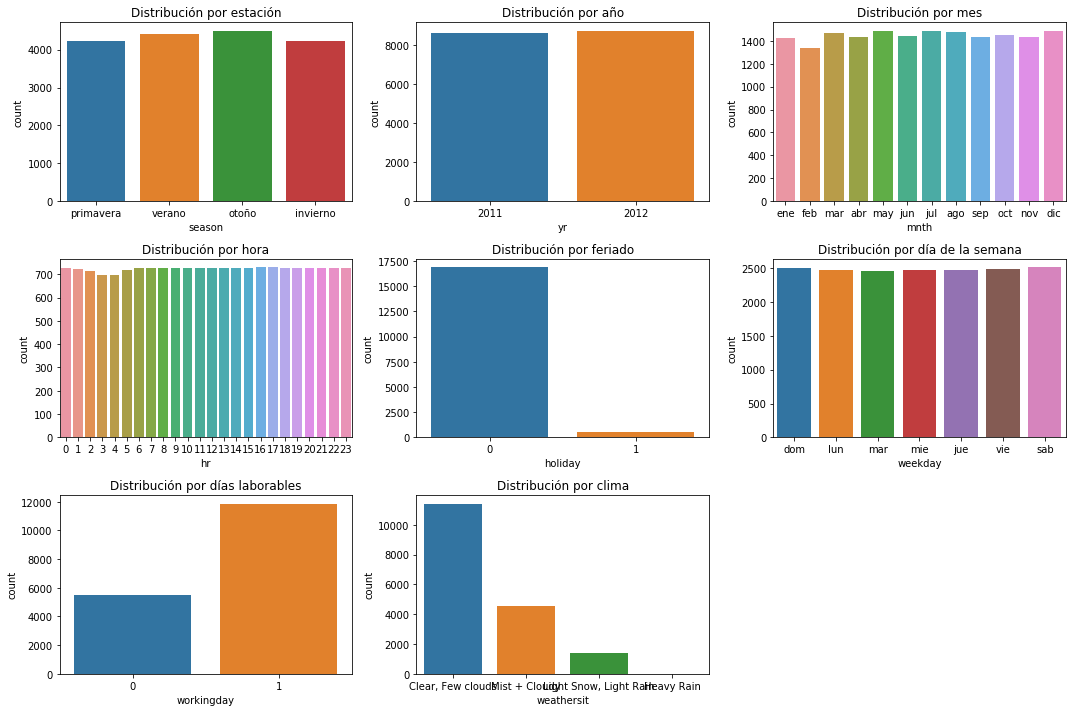

In [90]:
fig, axs = plt.subplots(3,3, figsize=(15 ,10))

# Distribución por estación
fp = sb.countplot('season', data=df, ax=axs[0][0])
fp.set_title('Distribución por estación')
fp.set_xticklabels(['primavera','verano', 'otoño', 'invierno'])

# Distribución por año
fp = sb.countplot('yr', data=df, ax=axs[0][1])
fp.set_title('Distribución por año')
fp.set_xticklabels(['2011', '2012'])

# Distribución por mes
fp = sb.countplot('mnth', data=df, ax=axs[0][2])
fp.set_title('Distribución por mes')
fp.set_xticklabels(['ene','feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic'])

# Distribución por hora
fp = sb.countplot('hr', data=df, ax=axs[1][0])
fp.set_title('Distribución por hora')

# Distribución por feriado
fp = sb.countplot('holiday', data=df, ax=axs[1][1])
fp.set_title('Distribución por feriado')

# Distribución por día de la semana
fp = sb.countplot('weekday', data=df, ax=axs[1][2])
fp.set_title('Distribución por día de la semana')
fp.set_xticklabels(['dom','lun', 'mar', 'mie', 'jue', 'vie', 'sab'])

# Distribución por días laborables
fp = sb.countplot('workingday', data=df, ax=axs[2][0])
fp.set_title('Distribución por días laborables')

# Distribución por clima
fp = sb.countplot('weathersit', data=df, ax=axs[2][1])
fp.set_title('Distribución por clima')
fp.set_xticklabels(['Clear, Few clouds','Mist + Cloudy', 'Light Snow, Light Rain', 'Heavy Rain'])

axs[2, 2].axis('off')
plt.tight_layout()

Como se puede observar en las gráficas, las distribuciones son bastante uniformes entre las categorías de cada variable, excepto en el caso de ditribución por feriado, pero al ser solamente un caso no es necesario su tratamiento, no afecta notablemente a la predicción.

#### Distribución de datos en variables continuas

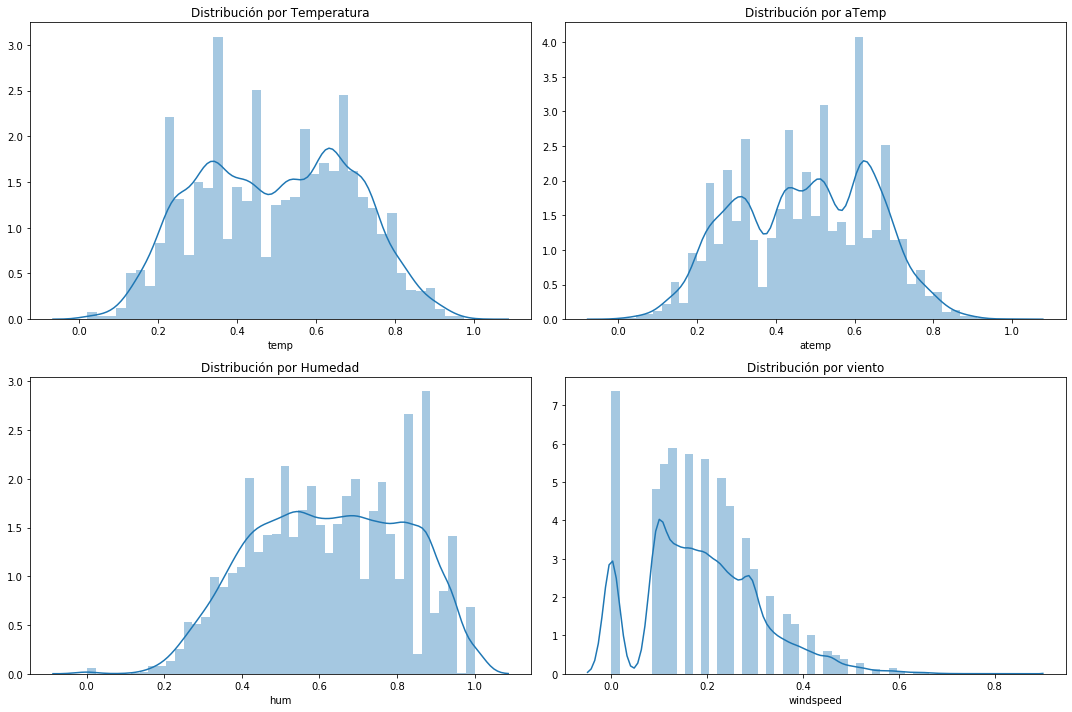

In [28]:
fig, axs = plt.subplots(2,2, figsize=(15 ,10))

# Distribución por temperatura
fp = sb.distplot(df.temp, ax=axs[0][0])
fp.set_title('Distribución por Temperatura')

# Distribución por atemp
fp = sb.distplot(df.atemp, ax=axs[0][1])
fp.set_title('Distribución por aTemp')

# Distribución por humedad
fp = sb.distplot(df.hum, ax=axs[1][0])
fp.set_title('Distribución por Humedad')

# Distribución por viento
fp = sb.distplot(df.windspeed, ax=axs[1][1])
fp.set_title('Distribución por viento')
plt.tight_layout()

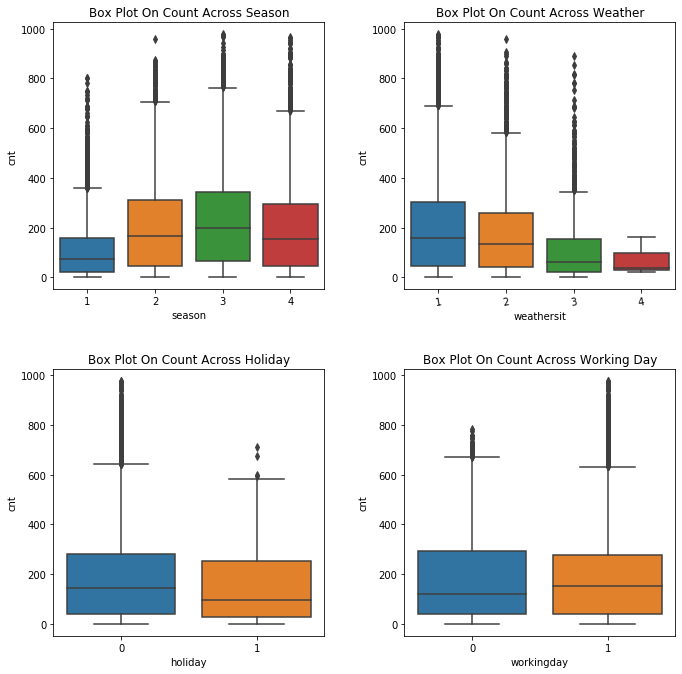

In [29]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Creamos una figura de 2x2
figure, axes = plt.subplots(nrows=2, ncols=2) # 2rows 2columns
plt.tight_layout()
figure.set_size_inches(10, 10)

# Step 2 : Creamos los subgráficos
# Gráfico de bigotes de los alquileres por season, weather, holiday, and workingday
sns.boxplot(x='season', y='cnt', data=df, ax=axes[0, 0])
sns.boxplot(x='weathersit', y='cnt', data=df, ax=axes[0, 1])
sns.boxplot(x='holiday', y='cnt', data=df, ax=axes[1, 0])
sns.boxplot(x='workingday', y='cnt', data=df, ax=axes[1, 1])

# Step 3: Configuración de los subgráficos
# titulo
axes[0, 0].set(title='Box Plot On Count Across Season')
axes[0, 1].set(title='Box Plot On Count Across Weather')
axes[1, 0].set(title='Box Plot On Count Across Holiday')
axes[1, 1].set(title='Box Plot On Count Across Working Day')

# 3.2 eliminar que se sobrepongan los titulos
axes[0, 1].tick_params('x', labelrotation=10) # rotate 10 degrees

In [91]:
df

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16.01
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40.00
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32.00
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13.00
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119.00
17375,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89.00
17376,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90.00
17377,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61.00


[Text(0.5, 0, 'temp'),
 Text(1.5, 0, 'atemp'),
 Text(2.5, 0, 'hum'),
 Text(3.5, 0, 'windspeed'),
 Text(4.5, 0, 'casual'),
 Text(5.5, 0, 'registered'),
 Text(6.5, 0, 'cnt')]

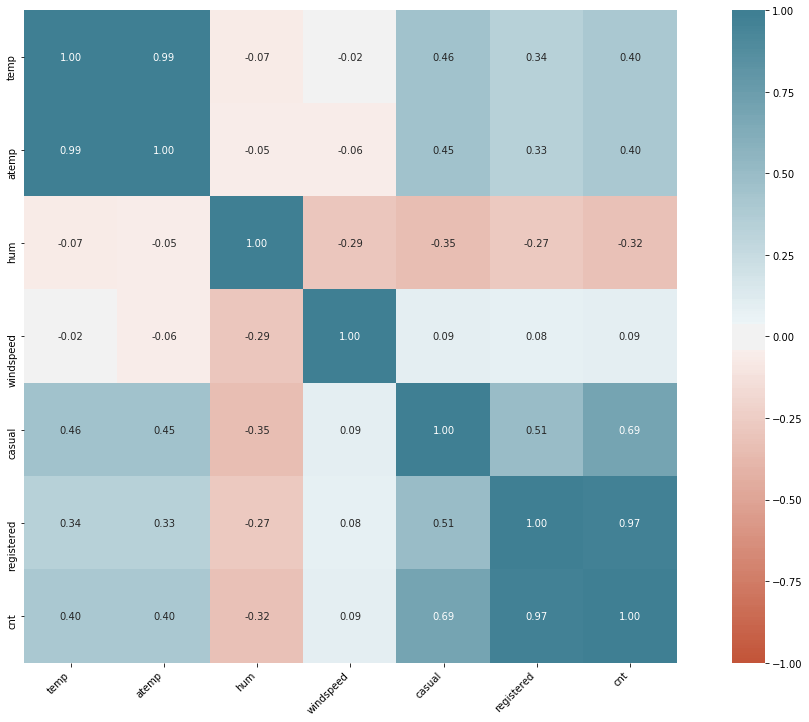

In [31]:
# Vamos a estudiar las correlaciones para entender las variables
# Calcula coeficiente de correlación de Pearson
corr = df.corr(method ='pearson') #por defecto Pearson ¿existe relación lineal entre variables?

# HeatMap con tamaño ampliado, cuadrado, divergencia con colores y con anotaciones de 2 decimales
plt.figure(figsize=(20,12))
ax = sns.heatmap(
 corr,
 vmin=-1, vmax=1, center=0,
 cmap=sns.diverging_palette(20, 220, n=200),
 square=True, annot=True, fmt=".2f"
)
# Rota las etiquetas del eje horizontal
ax.set_xticklabels(
 ax.get_xticklabels(),
 rotation=45,
 horizontalalignment='right'
)


In [92]:
df = df.drop(['casual', 'registered'], axis=1)

La distribución de los valores por cada variable numérica se encuentra bastante uniforme lo que colabora a la predicción en el modelo.

Se separa los datos en: **60% para entrenamiento** y **40% para prueba**, se utiliza la Técnica de **hold-out**:

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1],
                                                    df.iloc[:,-1],
                                                    test_size = 0.4,
                                                    random_state = 42)

Se verifica que se tiene el **60% para datos de entrenamiento** y **40% para datos de prueba**:

In [36]:
print("{0:2.2f}% de datos en el set de entrenamiento".format(len(X_train)/len(df.index)*100))
print("{0:2.2f}% de datos en el set de prueba".format(len(X_test)/len(df.index)*100))

60.00% de datos en el set de entrenamiento
40.00% de datos en el set de prueba


### Método 1: Árboles de decisión (Regresión)

#### Decidir la configuración del modelo
Se trabaja con 13 niveles para el árbol, entrenando y midiendo al modelo en cada nivel.

In [38]:
df

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16.01
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40.00
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32.00
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13.00
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,119.00
17375,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,89.00
17376,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,90.00
17377,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,61.00


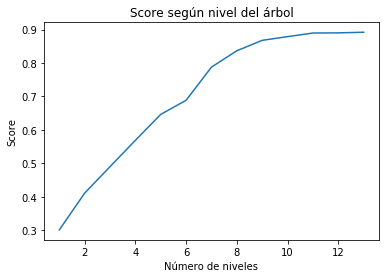

In [37]:
regr1 = tree.DecisionTreeRegressor(random_state=42)
scores = []
num_variables = len(list(df))
n_niveles = range(1, num_variables + 1)
for n in n_niveles:
    regr1.set_params(max_depth = n)
    regr1.fit(X_train, y_train)
    scores.append(regr1.score(X_test, y_test))
    
plt.title("Score según nivel del árbol")
plt.xlabel("Número de niveles")
plt.ylabel("Score")
plt.plot(n_niveles, scores)
plt.show()

Como se puede observar en la gráfica, el score más alto y donde se estabiliza el modelo es el nivel 12, a continuación se realiza la comprobación de lo observado encontrando en el arreglo de scores más alto.

In [39]:
# Obtener el número de árboles que obtuvo el mejor score y el menor error OOB
print('Con {} niveles se obtuvo el mayor score'.format(np.argmax(scores)))

Con 12 niveles se obtuvo el mayor score


#### Entrenar el modelo
Para entrenar el modelo se realiza con la profundidad de 12 ya que es el mejor nivel.
El modelo se está entrenando con el criterio de reducción de varianza "MSE".

In [40]:
regr1.set_params(max_depth = 12)
regr1.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

#### Probar el modelo

In [41]:
y_predict1 = regr1.predict(X_test)

#### Cálculo de métricas de evaluación

In [42]:
def calcular_metricas(real, predicted):
    mean_squared_error = metrics.mean_squared_error(real, predicted)
    
    print("Error Máximo: {:.2f}".format(metrics.max_error(real, predicted)))
    print("Error Absoluto Medio (MAE): {:.2f}".format(metrics.mean_absolute_error(real, predicted)))
    print("Error Cuadrático Medio (MSE): {:.2f}".format(mean_squared_error))
    print("Raíz del Error Cuadrático Medio (RMSE): {:.2f}".format(mean_squared_error**0.5))
    print("Logaritmo de la Raíz del Error Cuadrático Medio (RMLSE): {:.4f}".format(metrics.mean_squared_log_error(real, predicted)))
    print("Error Absoluto Medio: {:.4f}".format(metrics.median_absolute_error(real, predicted)))
    print("Coeficiente de Determinación R2 (r2 score): {:.4f}".format(metrics.r2_score(real, predicted)))

Se explican las métricas obtenidas:
* MAE: Este corresponde a la diferencia entre el valor real y el valor predicho, en nuestro caso el valor no es muy alto por lo que el modelo sí tiene un buen comportamiento.
* RMSE: Este corresponde a la raíz cuadrada de la media de la diferencia entre el valor real y el predicho al cuadrado, como podemos ver este valor tampoco es muy alto y al ser el encargado de penalizar errores grandes vemos que en nuestro modelo no se cuenta con grandes errores.
* RMLSE: el valor es muy bajo lo que indica que no existe under-prediction en el entrenamiento del modelo.
* R2: 0.89 nos demuestra que es un modelo fiable, pues mientras más se acerca a 1 así se determina.

In [43]:
calcular_metricas(y_test, y_predict1)

Error Máximo: 630.33
Error Absoluto Medio (MAE): 34.36
Error Cuadrático Medio (MSE): 3517.38
Raíz del Error Cuadrático Medio (RMSE): 59.31
Logaritmo de la Raíz del Error Cuadrático Medio (RMLSE): 0.1858
Error Absoluto Medio: 18.5465
Coeficiente de Determinación R2 (r2 score): 0.8900


##### Diagrama de dispersión de dos dimensiones

In [44]:
# Generar plot basado en la distribución de datos de prueba y datos de predicción
def dibujar_dispersion(real, predicted):
#     plt.figure()
    plt.scatter(real, predicted, s=20, edgecolor="black", c="darkorange", label="cnt")
    plt.xlabel("Datos reales")
    plt.ylabel("Datos de predicción")
#     plt.title("Gráfico de dispersión que muestra la relación y el error entre las predicciones y los valores reales.")
    plt.legend()
    plt.show()

Gráfico de dispersión que muestra la relación y el error entre las predicciones y los valores reales.


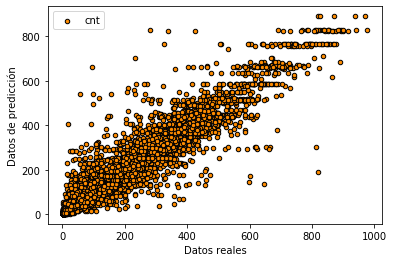

In [45]:
print("Gráfico de dispersión que muestra la relación y el error entre las predicciones y los valores reales.")
dibujar_dispersion(y_test, y_predict1)

Como se puede apreciar en el gráfico el modelo tiene correspondencia, se encuentra correctamente modelado y entrenado, se nota que un gran porcentaje de variables han sido predecidas correctamente.

### Método 2: Random Forests (Regresión)

#### Decidir la configuración del modelo

A continuación hacemos la prueba con diferentes valores para los hiperparámetros de número de árboles y de máximo número de columnas, de esta forma analizaremos qué modelo es el que mejor resultados nos va a dar.
* En el primer caso se trabaja cuando m=p, en nuestro caso m=12
* En el segundo caso se trabaja cuando m=p/2, en nuestro caso m=12/2=6
* En el tercer caso se trabaja cuando m=sqrt(p), en nuestro caso m=sqrt(12)

In [48]:
# Probar con diferentes valores de hiperparámetros (Se demora algunos minutos)
def obtener_mejor_configuracion(modelo, x, y, num_arboles):
    scores = [[],[],[]]
    errors = [[],[],[]]
    
    for n in num_arboles:
        #Primer caso
        modelo.set_params(n_estimators=n, max_features='auto')
        modelo.fit(x, y)
        scores[0].append(modelo.score(x, y))
        errors[0].append(1 - modelo.oob_score_)
        #Segundo caso
        modelo.set_params(n_estimators=n, max_features=6)
        modelo.fit(x, y)
        scores[1].append(modelo.score(x, y))
        errors[1].append(1 - modelo.oob_score_)
        #Tercer caso
        modelo.set_params(n_estimators=n, max_features='sqrt')
        modelo.fit(x, y)
        scores[2].append(modelo.score(x, y))
        errors[2].append(1 - modelo.oob_score_)
        
    fig, ax = plt.subplots(1 ,2, figsize=(12, 4))

    ax[0].set_title("Score según el número de árboles")
    ax[0].set_xlabel("Número de árboles")
    ax[0].set_ylabel("score")
    ax[0].plot(num_arboles, scores[0], label='m=p')
    ax[0].plot(num_arboles, scores[1], label='m=p/2')
    ax[0].plot(num_arboles, scores[2], label='m=sqrt(p)')
    ax[0].legend()

    ax[1].set_title("Error OOB según el número de árboles")
    ax[1].set_xlabel("Número de árboles")
    ax[1].set_ylabel("error")
    ax[1].plot(num_arboles, errors[0], label='m=p')
    ax[1].plot(num_arboles, errors[1], label='m=p/2')
    ax[1].plot(num_arboles, errors[2], label='m=sqrt(p)')
    ax[1].legend()
    plt.show()
    
    return scores, errors

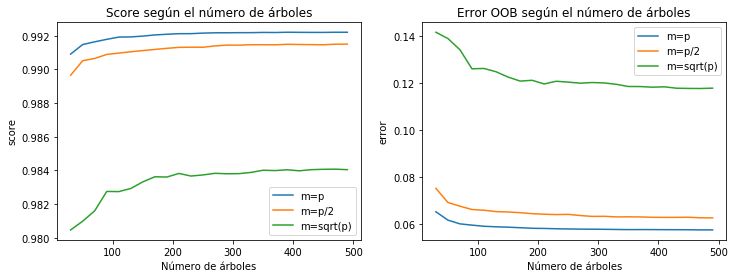

In [49]:
regr2 = RandomForestRegressor(random_state=42, n_jobs=-1, oob_score=True)
num_arboles = np.arange(30, 500, 20)
scores, errors = obtener_mejor_configuracion(regr2, X_train, y_train, num_arboles)

Se puede observar que el **Score más alto** y el **Error más bajo** se tiene cuando **m=p (línea azul)**, por lo que se desarrolla el entrenamiento y clasificación de acuerdo a este valor.

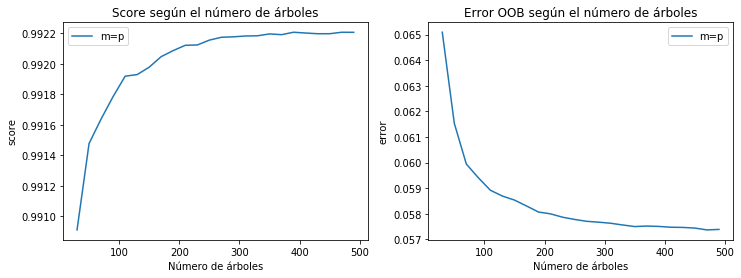

In [50]:
fig, ax = plt.subplots(1 ,2, figsize=(12, 4))

ax[0].set_title("Score según el número de árboles")
ax[0].set_xlabel("Número de árboles")
ax[0].set_ylabel("score")
ax[0].plot(num_arboles, scores[0], label='m=p')
ax[0].legend()

ax[1].set_title("Error OOB según el número de árboles")
ax[1].set_xlabel("Número de árboles")
ax[1].set_ylabel("error")
ax[1].plot(num_arboles, errors[0], label='m=p')
ax[1].legend()
plt.show()

In [51]:
# Obtener el número de árboles que obtuvo el mejor score y el menor error OOB
print('Con {} árboles se obtuvo el mayor score'.format((np.argmax(scores[0]) + 3) * 20))
print('Con {} árboles se obtuvo el menor error OOB'.format((np.argmin(errors[0]) + 3) * 20))

Con 420 árboles se obtuvo el mayor score
Con 500 árboles se obtuvo el menor error OOB


Tanto en la gráfica como en los cálculos realizados anteriormente se puede visualizar que a partir de **420 árboles** se estabiliza el modelo y se obtiene el mejor score por tanto este será el valor con el cual va a trabajar para entrenar el modelo.

#### Entrenar el modelo

Se utiliza **420 árboles** para entrenar al  modelo debido a que se obtubo el mejor Score y vemos que el error se estabiliza a partir de los 350 (aproximadamente). El modelo se está entrenando con el criterio de **Reducción de varianza "mse"** y **el método bootstrap**.

In [52]:
regr2.set_params(n_estimators=420, max_features='auto')
regr2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=420, n_jobs=-1, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)

#### Probar el modelo

In [53]:
y_predict2 = regr2.predict(X_test)

#### Cálculo de métricas de evaluación

In [54]:
calcular_metricas(y_test, y_predict2)

Error Máximo: 495.92
Error Absoluto Medio (MAE): 25.96
Error Cuadrático Medio (MSE): 1923.31
Raíz del Error Cuadrático Medio (RMSE): 43.86
Logaritmo de la Raíz del Error Cuadrático Medio (RMLSE): 0.1334
Error Absoluto Medio: 14.5762
Coeficiente de Determinación R2 (r2 score): 0.9398


Si aplicamos el mismo análisis de métricas que en los árboles de decisión se puede observar que el MAE, RMSE y RMLSE es inferior en Random Forest que en Árboles de decisión, además el coeficiente de determinación es más alto por lo que podemos afirmar que Random Forest presenta un modelo más fiable.

##### Diagrama de dispersión de dos dimensiones

Gráfico de dispersión que muestra la relación y el error entre las predicciones y los valores reales.


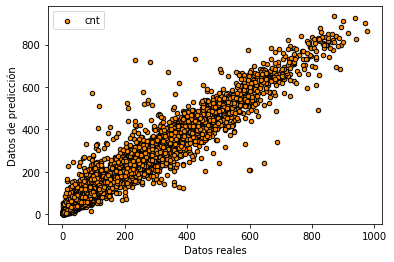

In [55]:
# Generar plot basado en la distribución de datos de prueba y datos de predicción
print("Gráfico de dispersión que muestra la relación y el error entre las predicciones y los valores reales.")
dibujar_dispersion(y_test, y_predict2)

## Conclusiones

Gráfico de dispersión que muestra la relación y el error entre las predicciones y los valores reales MODELO 1.
Gráfico 1


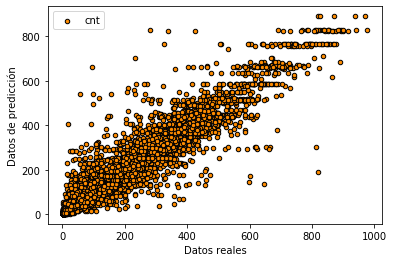

Gráfico de dispersión que muestra la relación y el error entre las predicciones y los valores reales MODELO 2.
Gráfico 2


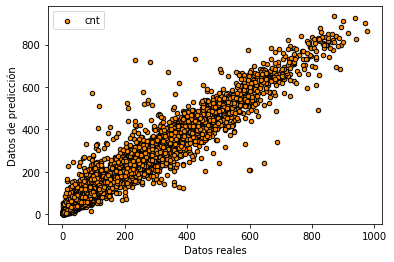

In [32]:
# Método 1: Árboles de decisión (Regresión)
print("Gráfico de dispersión que muestra la relación y el error entre las predicciones y los valores reales MODELO 1.")
print("Gráfico 1")
dibujar_dispersion(y_test, y_predict1)

# Método 2: Random Forests (Regresión)
print("Gráfico de dispersión que muestra la relación y el error entre las predicciones y los valores reales MODELO 2.")
print("Gráfico 2")
dibujar_dispersion(y_test, y_predict2)

* El **Gráfico 1** de dispersión muestra una menor distribución lineal en Árboles de decisión que en Random Forest que es el **Gráfico 2**. Por tanto del análisis de métricas y de la gráfica se concluye que el modelo Random Forest es mucho más fiable y con menos errores al momento de realizar predicciones numéricas (Regresión).

. | Árboles de decisión | Random Forests | 
------------ | ------------- | -------------
Error Máximo | 630.33 |495.92|
Error Absoluto Medio (MAE) | 34.36 | 25.96 |
Error Cuadrático Medio (MSE)	| 3517.38	| 1923.31
Raíz del Error Cuadrático Medio (RMSE)	| 59.31	| 43.86
Logaritmo de la Raíz del Error Cuadrático Medio (RMLSE)	| 0.1858	| 0.1334
Coeficiente de Determinación R2 (r2 score)	| 0.8900	| 0.9398



* En la tabla anterior se tiene listado los errores calculados con los dos modelos, se nota claramente al comparar uno a uno que el error generado por Random Forest es menor, por lo tanto, este es el modelo más eficiente para este ejercicio.
* De igual manera, al comparar el **Coeficiente de Determinación R2** entre los dos modelos, se nota que Ramdom Forest tiene un valor más alto, de esta forma se presenta como mejor modelo para este ejercicio.
* La **Raíz del Error Cuadrático Medio (RMSE)** que se tiene calculado en los dos métodos muestra claramente que en Random Fores en menor, esto indica que este modelo presenta menor distancia entre los datos reales y predecidos.

# Se repite el ejercicio haciendo el siguiente grupo y desarrollando un algoritmo de clasificación: grupo 1 si cnt<=20, grupo 2 en otro caso.

In [56]:
# Se divide en dos grupos de acuerdo a la columna cnt
df.loc[df.cnt <= 20, 'cnt_cat'] = 1
df.loc[df.cnt > 20, 'cnt_cat'] = 2
df = df.drop(['cnt'], axis=1)
# Se muestran los primeros 5 registros
display(df.head())

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt_cat
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,1.0
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,2.0
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,2.0
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,1.0
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1.0


Se separa los datos en: **60% para entrenamiento** y **40% para prueba** utilizando la técnica de **hold-out**:

In [57]:
Xcat = df.iloc[:,:-1].values
ycat = df.iloc[:,-1].values

le = preprocessing.LabelEncoder()
ycat = le.fit_transform(ycat)

Xcat_train, Xcat_test, ycat_train, ycat_test = train_test_split(Xcat, ycat, test_size = 0.4, random_state = 42)

Se asegura que se tiene el 60% para datos de entrenamiento y 40% para datos de prueba:

In [58]:
print("{0:2.2f}% de datos en el set de entrenamiento".format(len(Xcat_train)/len(df.index)*100))
print("{0:2.2f}% de datos en el set de prueba".format(len(Xcat_test)/len(df.index)*100))

60.00% de datos en el set de entrenamiento
40.00% de datos en el set de prueba


Al realizar un entrenamiento con el 60% se aporta con la mayor cantidad de datos, los cuales permiten tener 
un mejor entrenamiento y luego el 40% de test permite el modelamiento preciso del sistema.


### Método 1: Arboles de desición (Clasificasión)

#### Decidir la configuración del modelo

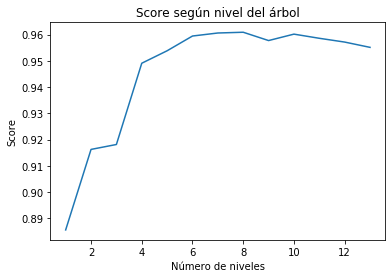

In [59]:
cat1 = tree.DecisionTreeClassifier(random_state=42)
scores = []
num_variables = len(list(df))
n_niveles = range(1, num_variables + 1)


for n in n_niveles:
    cat1.set_params(max_depth = n)
    cat1.fit(Xcat_train, ycat_train)
    scores.append(cat1.score(Xcat_test, ycat_test))
    
plt.title("Score según nivel del árbol")
plt.xlabel("Número de niveles")
plt.ylabel("Score")
plt.plot(n_niveles, scores)
plt.show()

Al realizar la configuracion del modelo se nota el nivel en el cual el modelo se estabiliza de acuerdo al score
dado, en la gráfica el presente modelo es estable en el **score 0,96** aproximadamente y esta en el **nivel 7**

In [60]:
# Obtener el número de árboles que obtuvo el mejor score y el menor error OOB
print('Con {} niveles se obtuvo el mayor score'.format(np.argmax(scores)))

Con 7 niveles se obtuvo el mayor score


#### Entrenar el modelo

In [61]:
cat1.set_params(max_depth = 7)
cat1.fit(Xcat_train, ycat_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

#### Probar el modelo

In [62]:
y_predict1 = cat1.predict(Xcat_test)

#### Cálculo de métricas de evaluación

In [63]:
def calcular_metricas_cat(real, predicted):
    (tp, fp), (tn, fn) = metrics.confusion_matrix(real, predicted)
    print("Exactitud (Accuracy): {:.4f}".format(metrics.accuracy_score(real, predicted)))
    print("Especificidad: {:.4f}".format(tn/(tn + fp)))
    print("Sensibilidad: {:.4f}".format(tp/(tp + fn)))
    print("Precisión: {:.4f}".format(metrics.precision_score(real, predicted)))
    print("Recall: {:.4f}".format(metrics.recall_score(real, predicted)))
    print("F1: {:.4f}".format(metrics.f1_score(real, predicted)))

In [41]:
calcular_metricas_cat(ycat_test, y_predict1)

Exactitud (Accuracy): 0.9606
Especificidad: 0.4416
Sensibilidad: 0.1545
Precisión: 0.9736
Recall: 0.9790
F1: 0.9763


El primer modelo arroja como:<br>
* **Exactitud: 0.96.** Este dato indica que se tiene un 96% de prediciones correctas, siendo los óptimo el 100%.
* **Especificidad:0.1545.** Indica la taza negativa verdadera fue precicha como negativa así se tiene el 15%.
* **Sensibilidad: 0.1545.** Es una medida que indica que proporción de predicciones verdaderas es del 15%, muy baja.
* **Precisión: 0.9736.** Se evalua los datos por su desempeño de predicciones positivas con un 97%.
* **F1: 0.9763.** Indica la predicción de todod los falsos Positivos y falsos negativos, tiene un 97% de predicción correcta de valores negativos.

#### Matriz de confusión

In [64]:
def dibujar_matriz_confusion(real, predicted, clases):
    mc = metrics.confusion_matrix(real, predicted)
    matriz_confuncion = pd.DataFrame(mc, index = [i for i in clases], columns = clases)
    
    fig, ax = plt.subplots()
    ax = sb.heatmap(
        matriz_confuncion,
        fmt='.4g',
        annot = True,
        annot_kws={'size': 16},
        cmap= 'Blues_r',
        cbar = False)
    ax.xaxis.set_label_position('top')
    pos, textvals = plt.yticks(np.arange(2)+0.5, clases, rotation=1, va='center')
    plt.title('Matriz de confusión')
    plt.ylabel('Clase actual')
    plt.xlabel('Clase de predicción')
    plt.ylim(2, 0)
    plt.show()

    print('Tasa de verdaderos positivos ({0}): {1}'.format('<=20', mc[0][0]))
    print('Tasa de falsos positivos: {0}'.format(mc[0][1]))
    print('Tasa de Tasa de verdaderos negativos ({0}): {1}'.format('>20', mc[1][1]))
    print('Tasa de falsos negativos: {0}'.format(mc[1][0]))

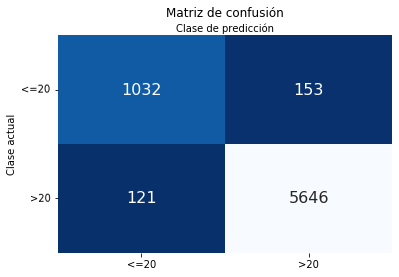

Tasa de verdaderos positivos (<=20): 1032
Tasa de falsos positivos: 153
Tasa de Tasa de verdaderos negativos (>20): 5646
Tasa de falsos negativos: 121


In [78]:
nombre_clases = ['<=20','>20']
dibujar_matriz_confusion(ycat_test, y_predict1, clases=nombre_clases)

De acuerdo a los dos grupos generados inicialmente se puede observar en la Matriz de Confusión los datos obtenidos como TP y FP, esto va de acuerdo a los valores antes obtenidos con el cálculo de las matricez de error, lo cual permite tener un desarrollo del modelo más precisio.

#### Curva ROC y Área bajo la curva (AUC)

In [67]:
def dibujar_curva_roc(real, predicted):
    fpr, tpr, _ = metrics.roc_curve(real, predicted)
    auc = metrics.auc(fpr, tpr)
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title('Curva ROC')
    plt.show()

    print("Área bajo la curva (AUC): {:.4f}".format(auc))

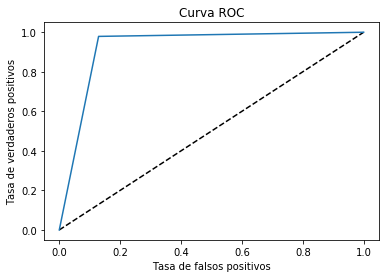

Área bajo la curva (AUC): 0.9250


In [68]:
dibujar_curva_roc(ycat_test, y_predict1)

Al realizar la curva **ROC**, en base a los resultados obtenidos por la matriz de error, se muestra que el area 
bajo la curva tiene un valor estable en 0,9250 es decir se tiene un modelo de preción muy confiable.
La gráfica muestra que el modelo tiene un 92% de fiabilidad, ya que tiene una alta precisión de distinguir.

### Método 2: Random Forests (Clasificasión)

#### Decidir la configuración del modelo

A continuación se hace la prueba con diferentes valores para los hiperparámetros de número de árboles y de máximo número de columnas, de esta forma se analiza que modelo es el que mejor resultados va a entregar.

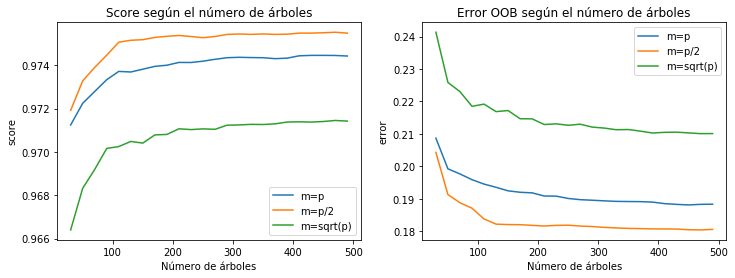

In [70]:
cat2 = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)
scores, errors = obtener_mejor_configuracion(regr2, Xcat_train, ycat_train, num_arboles)

Se observa que el Score más alto y el error mas bajo nos da cuando **m=p/2**

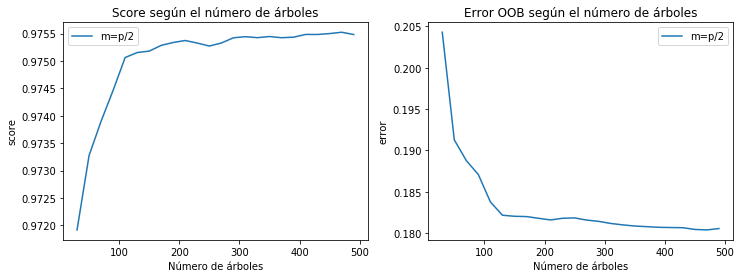

In [71]:
fig, ax = plt.subplots(1 ,2, figsize=(12, 4))

ax[0].set_title("Score según el número de árboles")
ax[0].set_xlabel("Número de árboles")
ax[0].set_ylabel("score")
ax[0].plot(num_arboles, scores[1], label='m=p/2')
ax[0].legend()

ax[1].set_title("Error OOB según el número de árboles")
ax[1].set_xlabel("Número de árboles")
ax[1].set_ylabel("error")
ax[1].plot(num_arboles, errors[1], label='m=p/2')
ax[1].legend()
plt.show()

In [72]:
# Obtener el número de árboles que obtuvo el mejor score y el menor error OOB
print('Con {} árboles se obtuvo el mayor score'.format((np.argmax(scores[0]) + 3) * 20))
print('Con {} árboles se obtuvo el menor error OOB'.format((np.argmin(errors[0]) + 3) * 20))

Con 480 árboles se obtuvo el mayor score
Con 480 árboles se obtuvo el menor error OOB


Al realizar la gráfica se vizualiza que, a partir de los 480 árboles se tiene un Score mayor conjuntamente 
con la estabilidad del modelo y esto también lo reafirma los cálculos antes realizados, con estos datos se puede 
realizar sin problema el entrenamiento del modelo.

#### Entrenar el modelo

Se utiliza 480 árboles para entrenar al modelo planteado ya que se obtiene el mejor score y menor error.

In [73]:
cat2.set_params(n_estimators=480, max_features=6)
cat2.fit(Xcat_train, ycat_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=480,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

#### Probar el modelo

In [74]:
y_predict2 = cat2.predict(Xcat_test)

#### Cálculo de métricas de evaluación

In [75]:
calcular_metricas_cat(ycat_test, y_predict2)

Exactitud (Accuracy): 0.9669
Especificidad: 0.4348
Sensibilidad: 0.1569
Precisión: 0.9776
Recall: 0.9827
F1: 0.9801


Al hacer la comparacion de matrices de error tanto en Randon Forest como en Árboles de decisión se tiene una mayor
precisión utilizando el segundo método (Randon Forest), es decir el modelo que se está desarrollando por clasificación es 
mas confiable y exacto .

#### Matriz de confusión

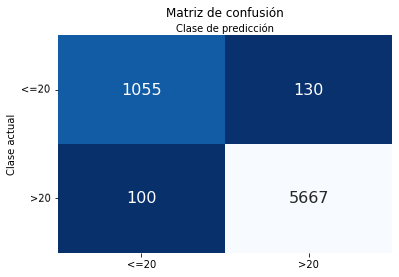

Tasa de verdaderos positivos (<=20): 1055
Tasa de falsos positivos: 130
Tasa de Tasa de verdaderos negativos (>20): 5667
Tasa de falsos negativos: 100


In [79]:
dibujar_matriz_confusion(ycat_test, y_predict2, clases=nombre_clases)

#### Curva ROC y Área bajo la curva (AUC)

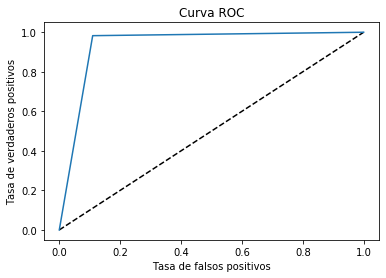

Área bajo la curva (AUC): 0.9365


In [80]:
dibujar_curva_roc(ycat_test, y_predict2)

#### Reporte de clasificación

In [81]:
print(metrics.classification_report(ycat_test, y_predict2, target_names=nombre_clases))

              precision    recall  f1-score   support

        <=20       0.91      0.89      0.90      1185
         >20       0.98      0.98      0.98      5767

    accuracy                           0.97      6952
   macro avg       0.95      0.94      0.94      6952
weighted avg       0.97      0.97      0.97      6952



Al realizar el reporte estadístico y compararlo con el modelo de Árboles, Random Forest nos brinda un modelo mas confiable y preciso al desarrollarlo por clasificación.

 Al haber realizado la clasificacion entre los valos <=20 y >20, 

## Conclusiones

* Al analizar los datos de la tabla comparativa presentada, se nota que el Modelo Random Forest tiene mejor predicción.

. | Árboles de decisión | Random Forests 
------------ | ------------- | -------------
Exactitud (Accuracy) | 0.9606 |0.9669
Especificidad | 0.4416 |0.4348
Sensibilidad | 0.1545 |0.1569
Precisión | 0.9736 |0.9776
Recall | 0.9790 |0.9827
F1|0.9763|0.9801

* En cuanto a la **Exactitud**, el modelo Random Forest presenta una leve superioridad en el porcentaje de las predicciones correctas, así Random Forest solo supera a Árboles de decisión por 0.0063 lo que corresponde a un 0.63%, este se puede considerar un valor despreciable. Se puede indicar que los dos modelos tienen casi la misma Exactitud.
* Con respecto a la **Especificidad** que indica la taza negativa verdadera que fue predecida como negativa el Model Random Forest también presenta una leve superioridad. Esta diferencia es muy pequeña.
* La **Precisión** evalua los datos por su desempeño de predicciones positivas con un 97.77%. Nuevamente no se tiene mucha diferencia entre los dos modelos.
* **F1** Indica la predicción de todod los falsos Positivos y falsos negativos, el modelo Random Forest tiene un 98.01% de predicción correcta de valores negativos frente al 97.63% que presenta los Árboles de decisión.
* De forma generalizada se concluye que el metodo Random Forest presenta una mayor eficacia frente al modelo Árboles de decisión apicados al presente dataset.